In [5]:
# Importing all necessary libriraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
from scipy.stats import linregress
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error, cohen_kappa_score, accuracy_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from google.colab import files
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeRegressor

uploaded = files.upload()


Saving winequality-white.csv to winequality-white (1).csv


In [6]:
# Import data into datafram
winedata = pd.read_csv('winequality-white.csv', delimiter=';')

# Converting seperators (, to .)
for column in winedata.columns:
    if not pd.api.types.is_numeric_dtype(winedata[column]):
        try:
            winedata[column] = pd.to_numeric(winedata[column].str.replace('.', '', regex=False).str.replace(',', '.'), errors='raise')
        except ValueError:
            pass

# Head of DataFrame
print(winedata.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

In [7]:
winedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [8]:
winedata.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


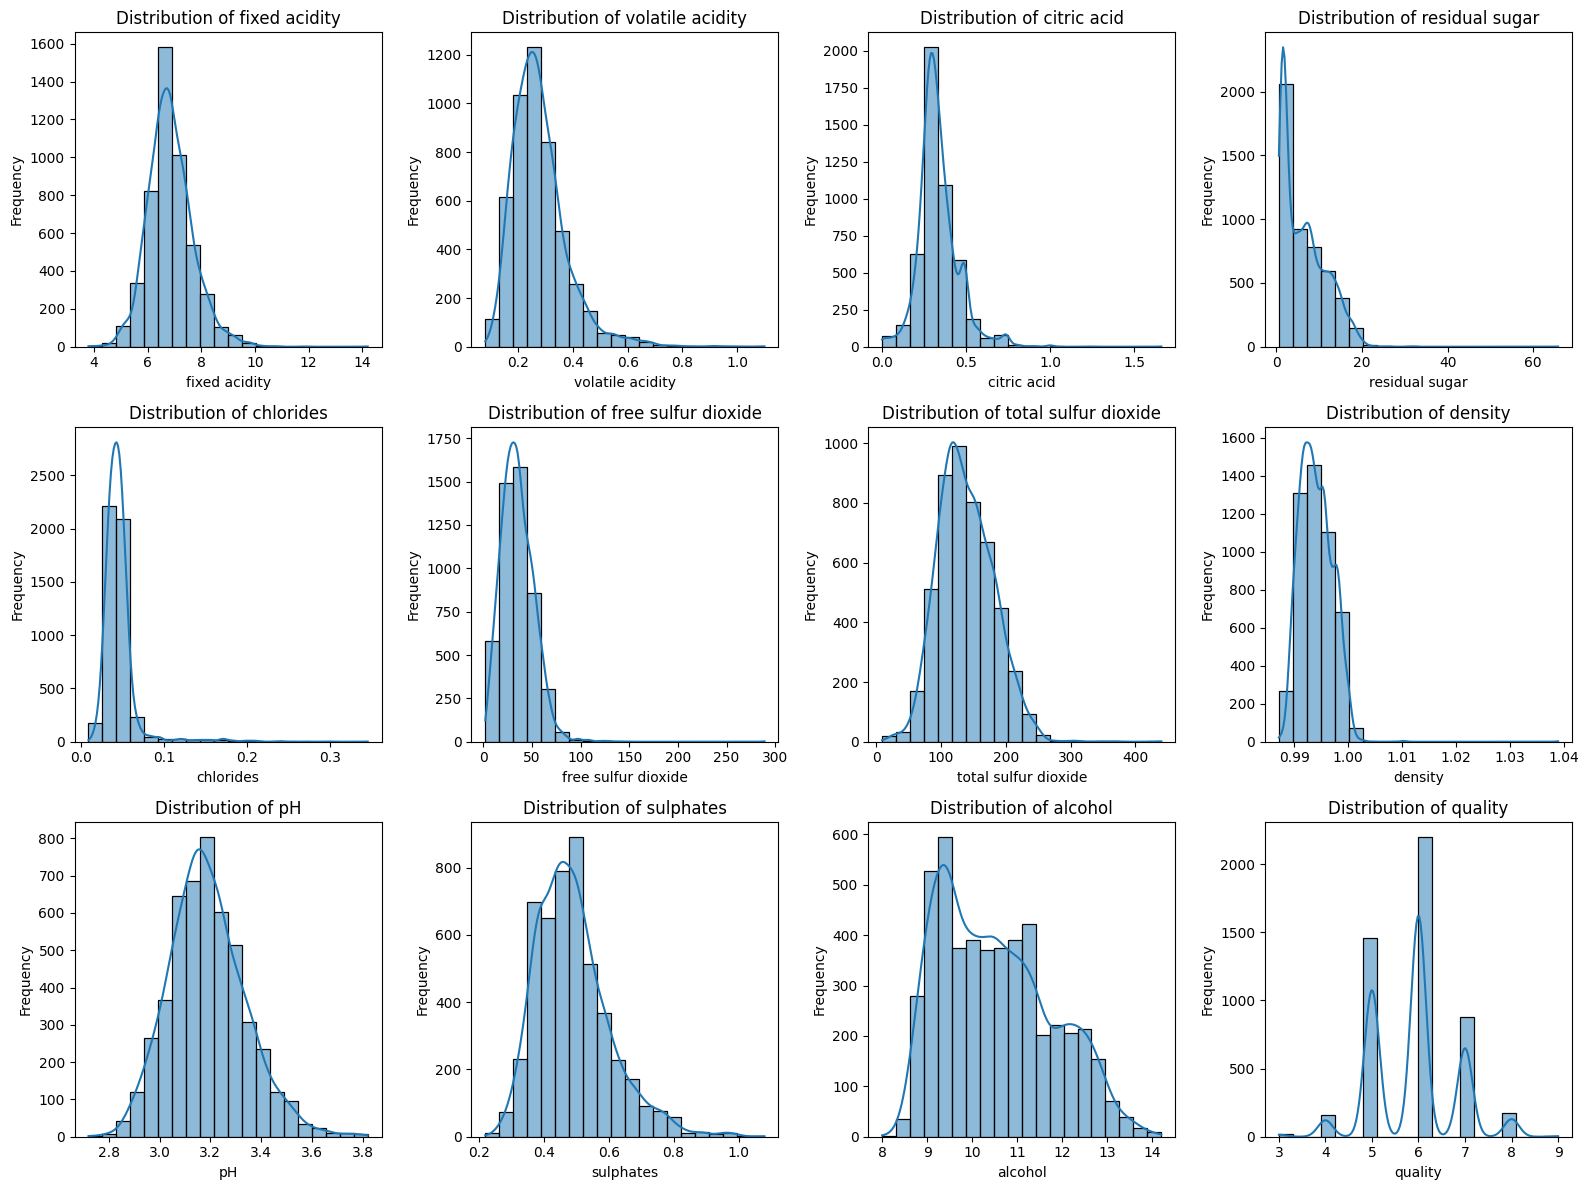

In [9]:
# Evaluation the dataset

#List of features
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
            'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
            'pH', 'sulphates', 'alcohol', 'quality']

# Create a figure with subplots
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

# Loop through features and create histograms with fewer bins
for i, feature in enumerate(features):
    sns.histplot(winedata[feature], ax=axes[i], kde=True, bins=20)  # Reduced bins to 10
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Adjust layout + plot
plt.tight_layout()
plt.show()

In [10]:
# Counting each quality score
winedata['quality'].value_counts()

,count
quality,
6,2198
5,1457
7,880
8,175
4,163
3,20
9,5


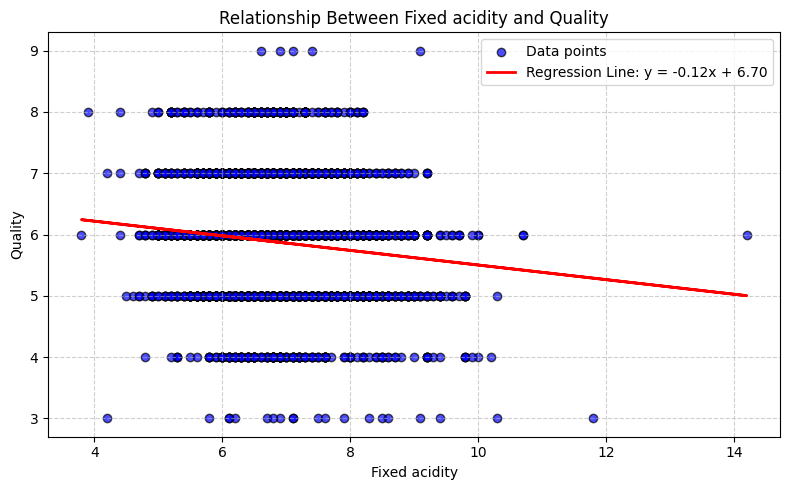

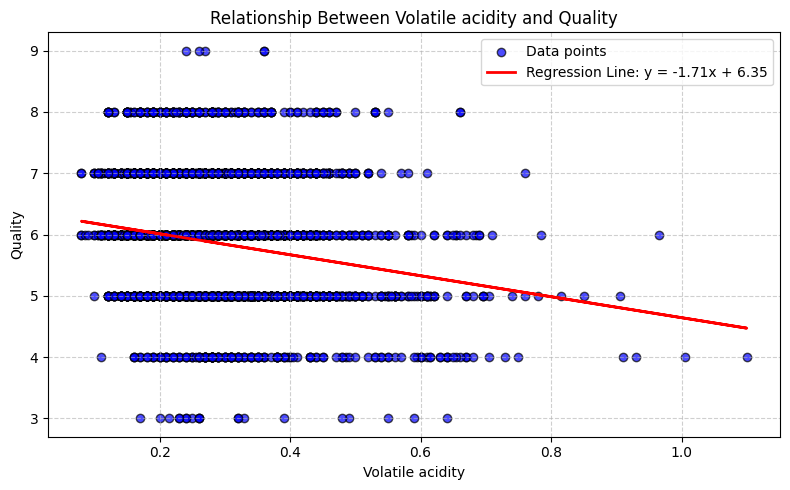

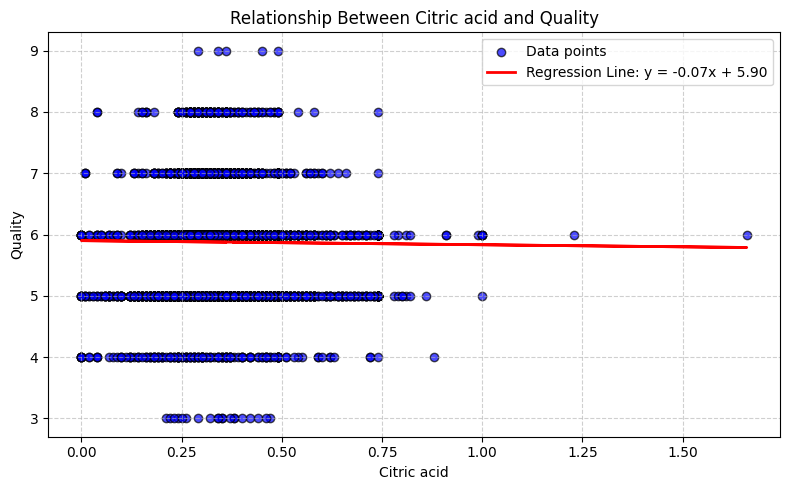

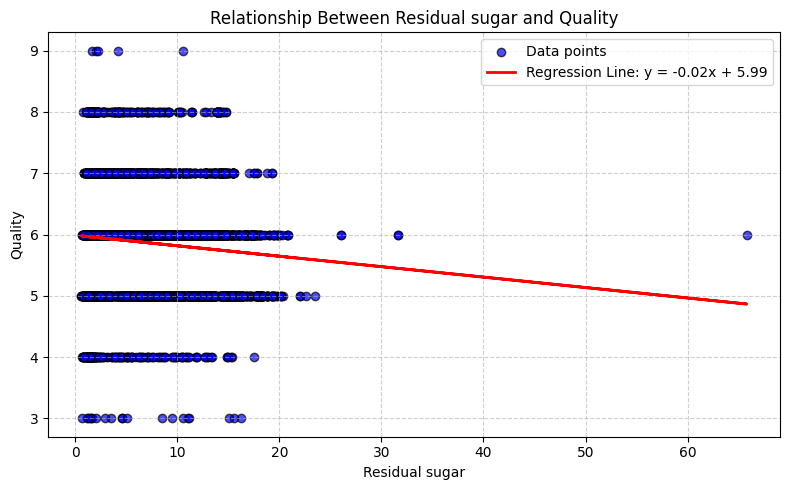

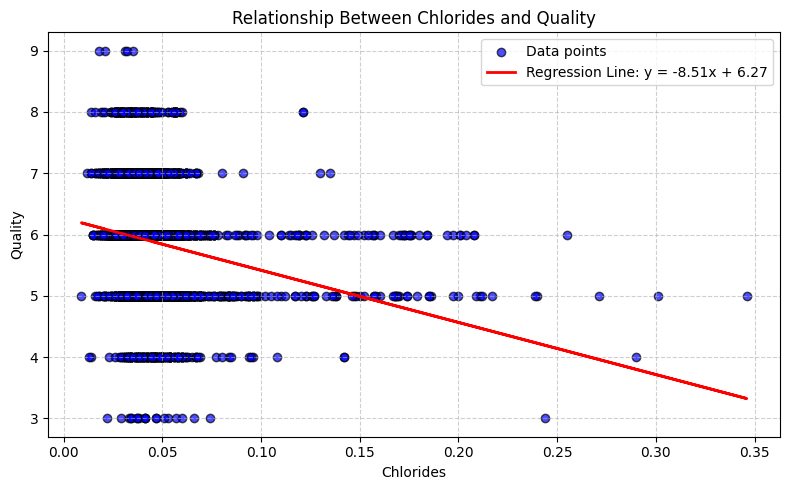

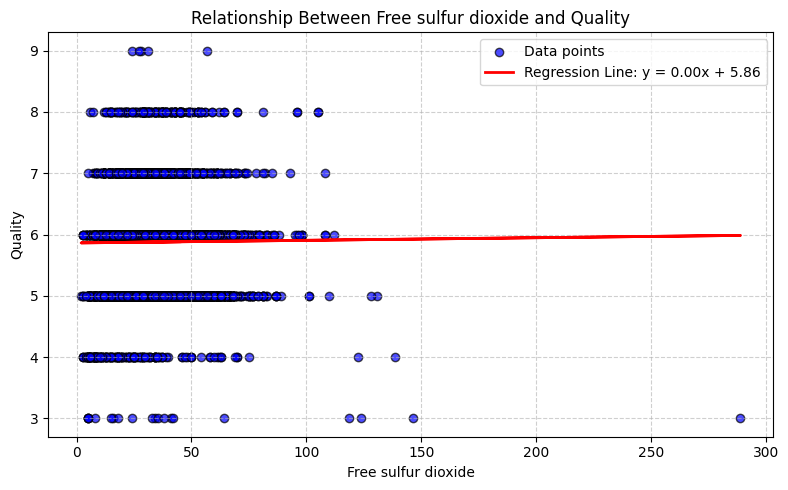

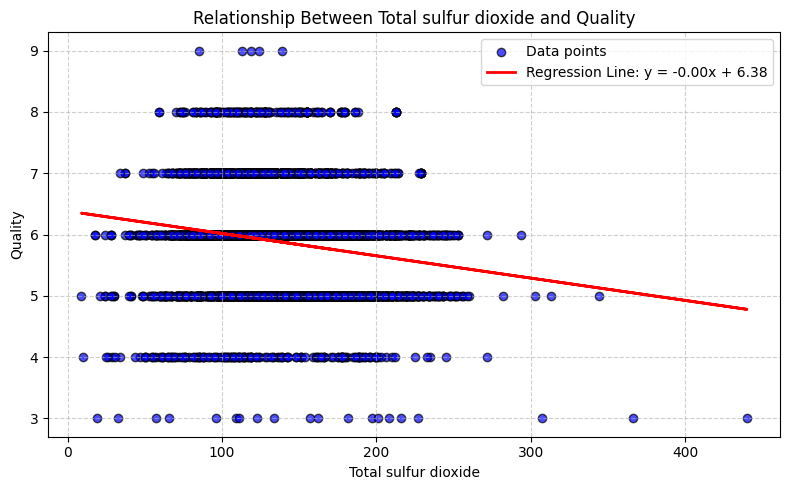

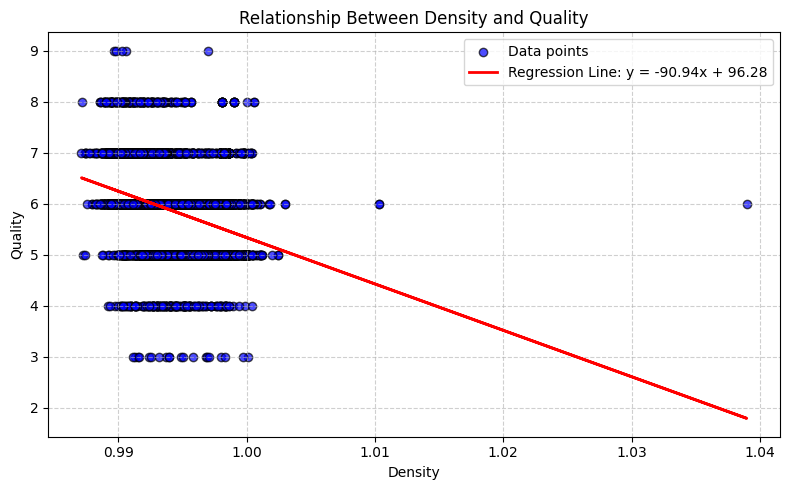

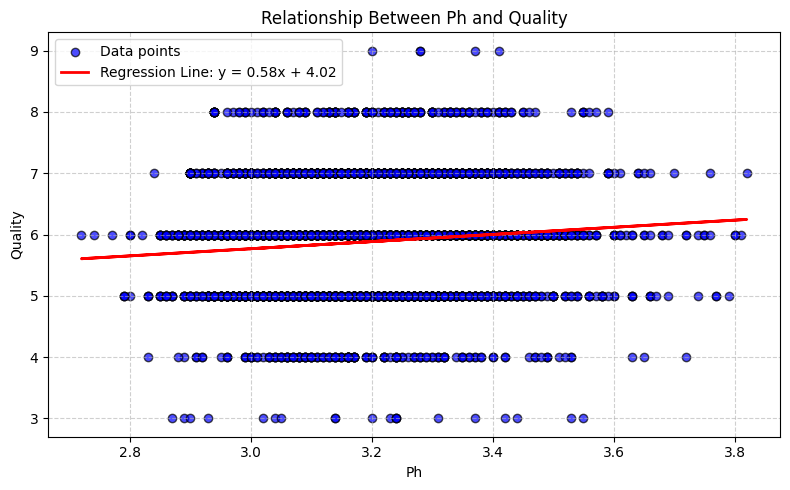

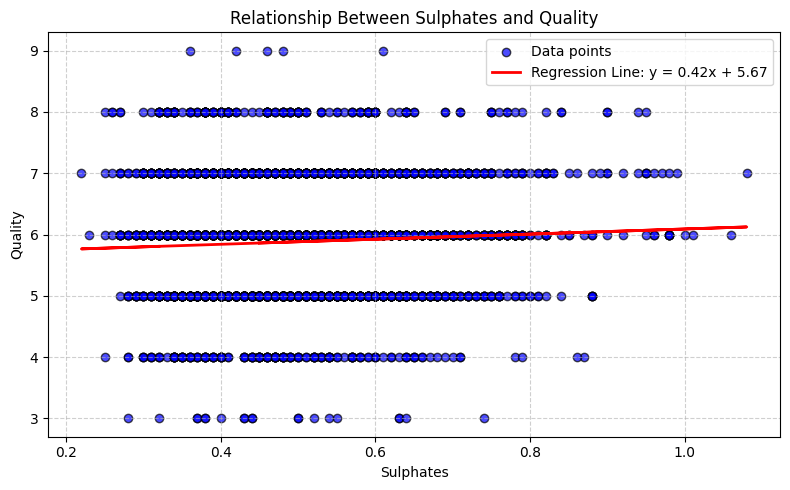

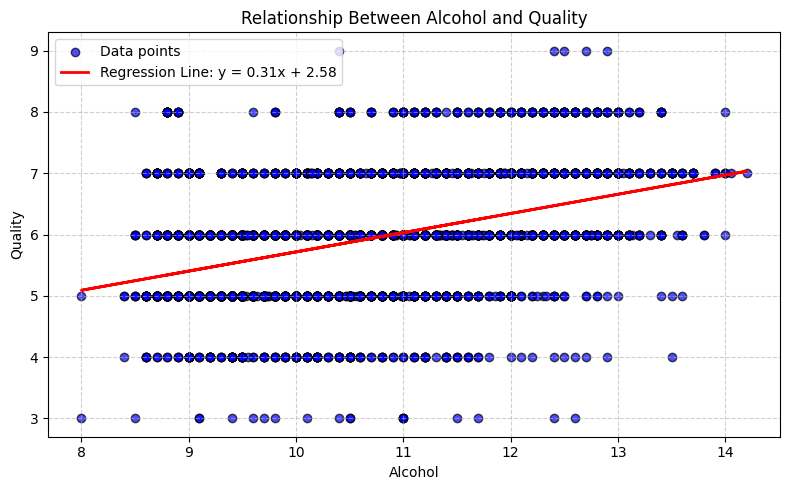

In [11]:
#Check for linearity

# Specify the target (dependent) variable
target_column = 'quality'

# Extract features (all columns except the target)
feature_columns = [col for col in winedata.columns if col != target_column]

# Loop through each feature and plot linear relationship
for feature in feature_columns:
    x = winedata[feature].values
    y = winedata[target_column].values

    # Scatterplot to check linearity
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y, alpha=0.7, color='blue', edgecolor='k', label='Data points')
    plt.title(f'Relationship Between {feature.capitalize()} and {target_column.capitalize()}')
    plt.xlabel(f'{feature.capitalize()}')
    plt.ylabel(f'{target_column.capitalize()}')

    # Plot the regression line
    slope, intercept = np.polyfit(x, y, 1)
    y_fit = slope * x + intercept
    plt.plot(x, y_fit, color='red', linewidth=2, label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

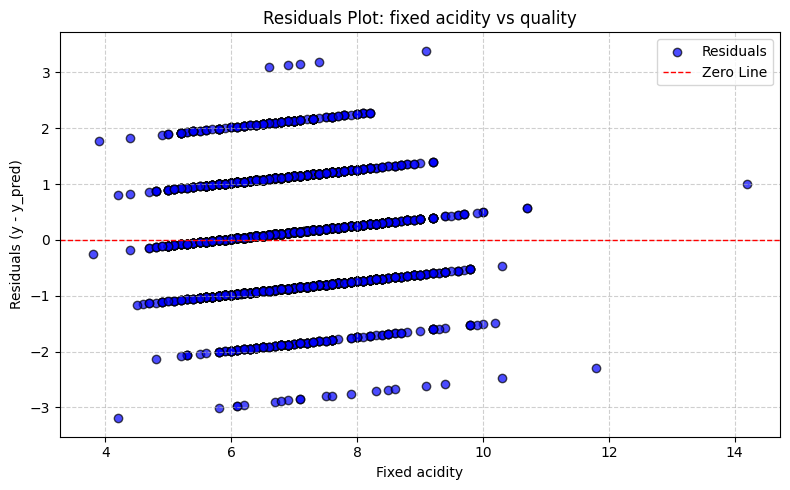

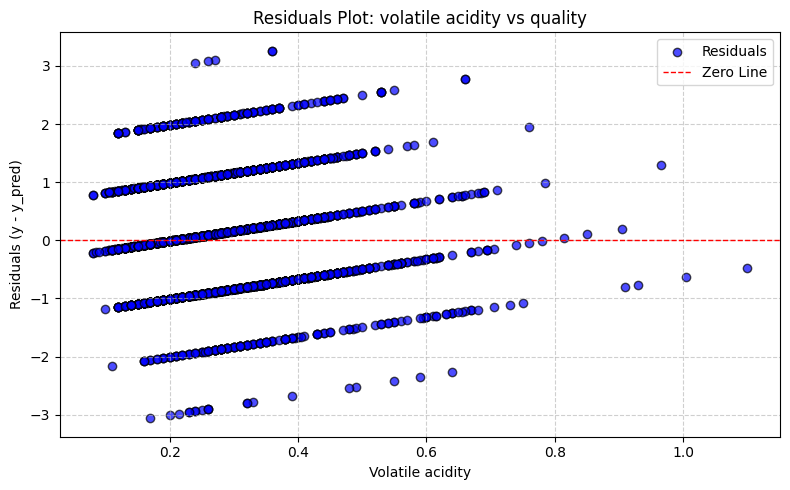

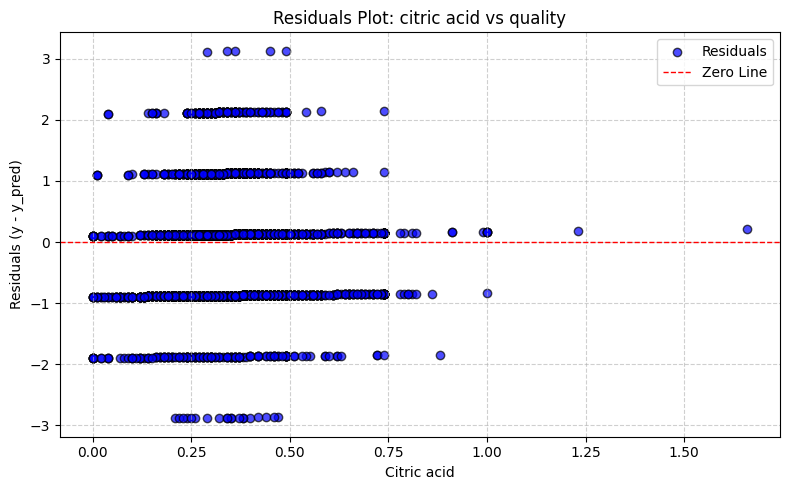

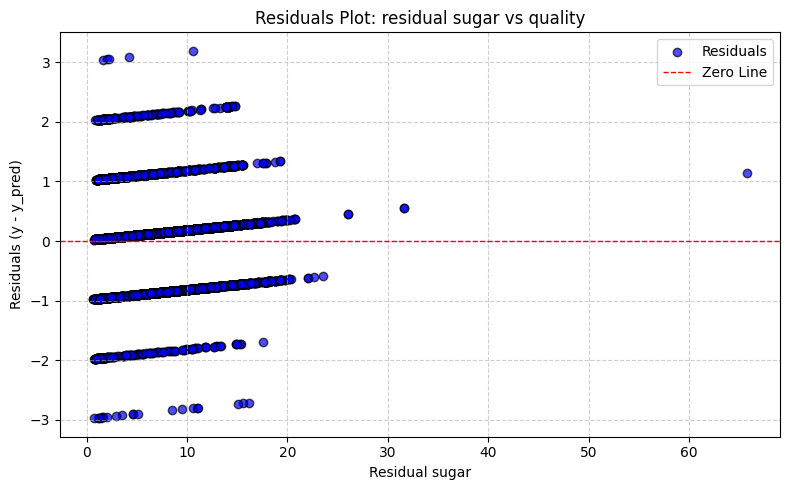

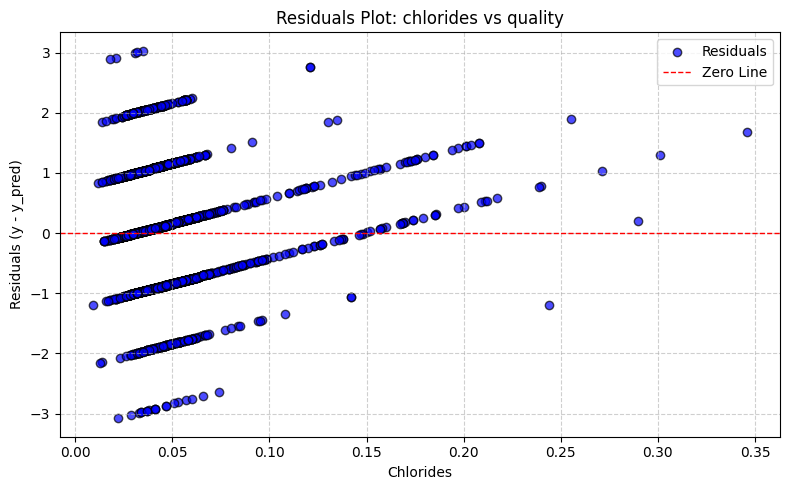

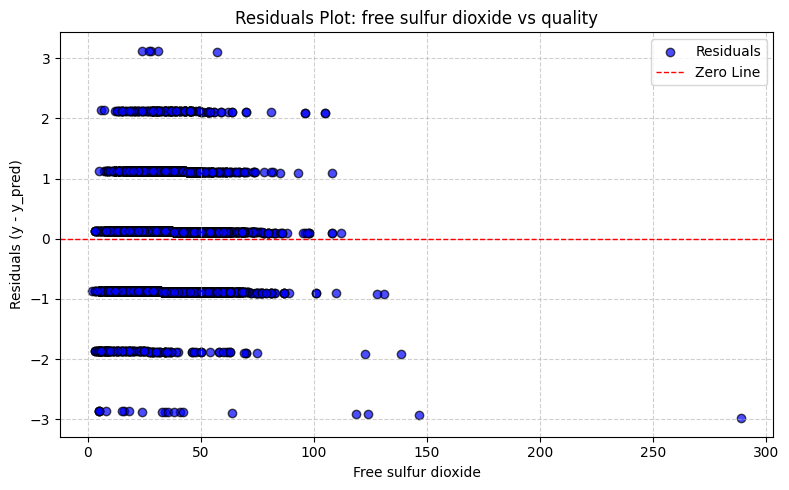

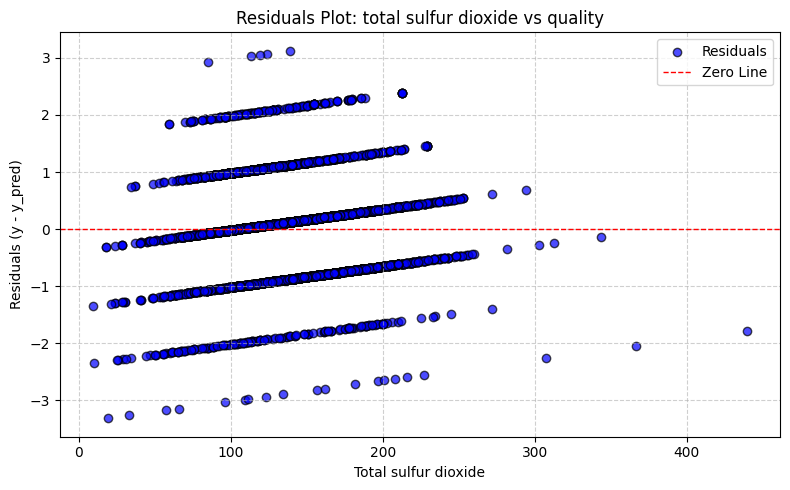

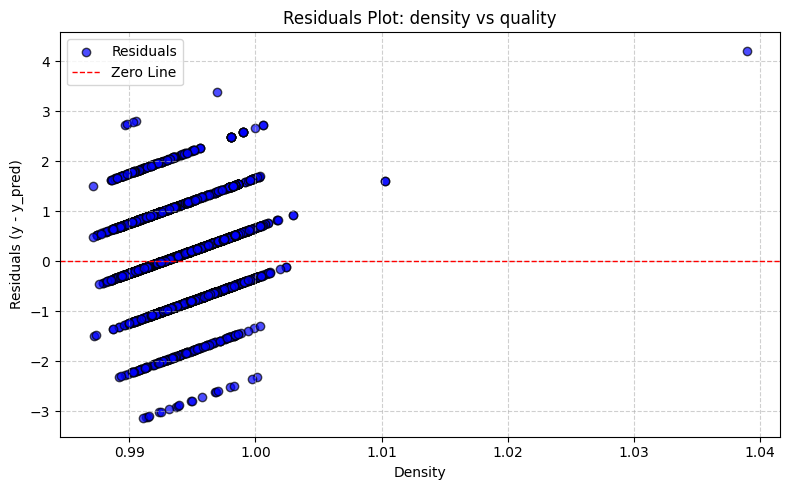

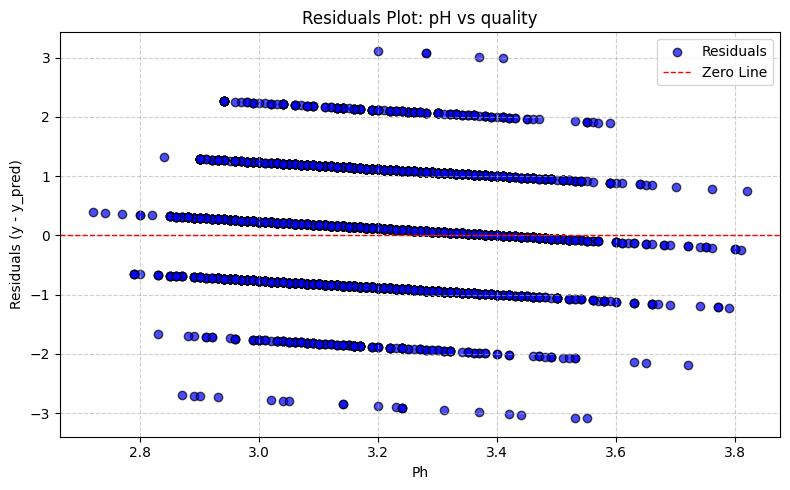

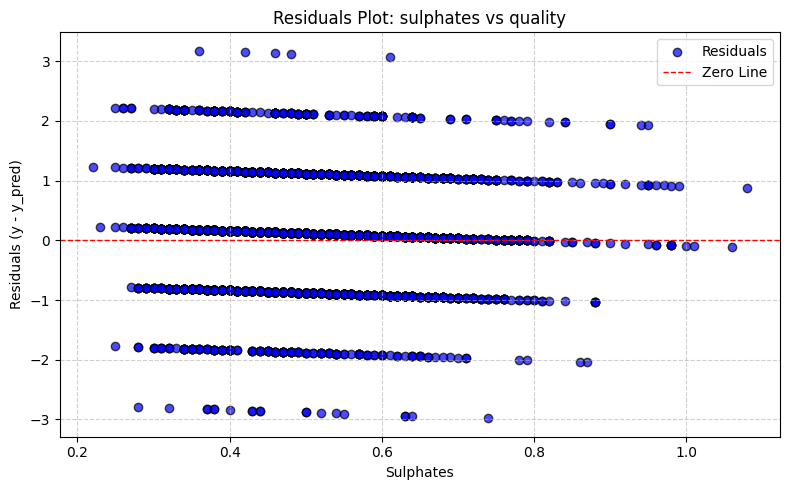

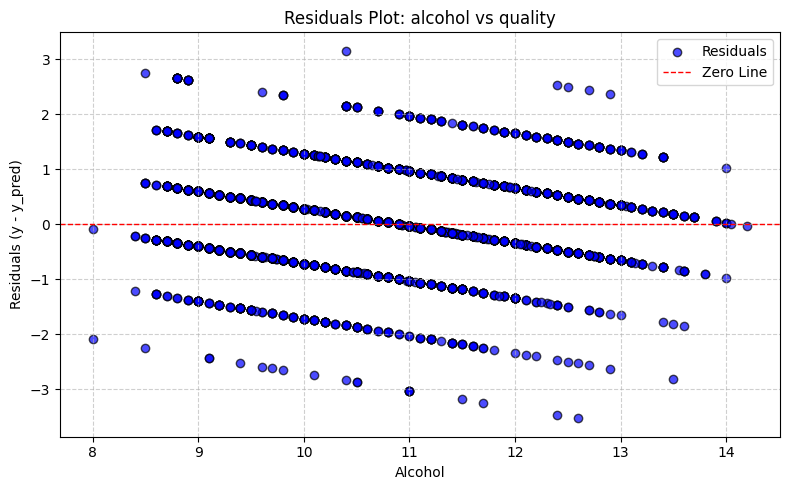

In [12]:
# Check homoscedasticity
#Target
target_column = 'quality'

# Extract features (all columns except the target)
feature_columns = [col for col in winedata.columns if col != target_column]

# Loop through each feature and plot residuals
for feature in feature_columns:

    x = winedata[feature].values
    y = winedata[target_column].values

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    y_pred = slope * x + intercept

    # Calculate residuals
    residuals = y - y_pred

    # Scatterplot of residuals vs independent variable
    plt.figure(figsize=(8, 5))
    plt.scatter(x, residuals, alpha=0.7, color='blue', edgecolor='k', label='Residuals')
    plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Line')
    plt.title(f'Residuals Plot: {feature} vs {target_column}')
    plt.xlabel(f'{feature.capitalize()}')
    plt.ylabel('Residuals (y - y_pred)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


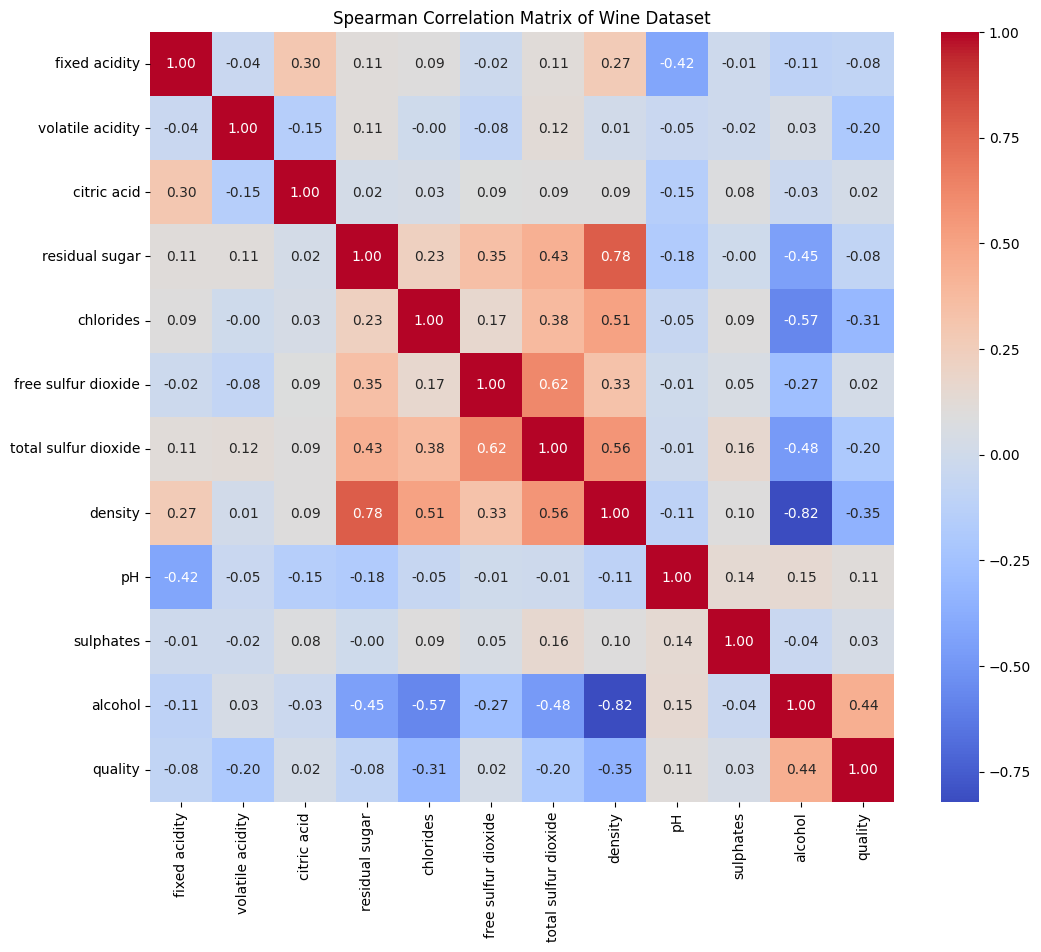

In [13]:
# Spearman correlation
correlation_matrix = winedata.corr(method='spearman')

# Getting unique values and frequencies
unique_values, frequencies = np.unique(correlation_matrix, return_counts=True)

# Visualizing the correlation matrix with a heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation Matrix of Wine Dataset')
plt.show()


In [14]:
# Creating a pipeline for filling in missing values with medians and standardizing the data
transform_pipeline = Pipeline([
                               ('imputer', SimpleImputer(strategy="median")),
                               ('std_scaler', StandardScaler()),])
transform_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('std_scaler', StandardScaler())])

['volatile acidity', 'residual sugar', 'free sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Run 1/20...
Run 2/20...
Run 3/20...
Run 4/20...
Run 5/20...
Run 6/20...
Run 7/20...
Run 8/20...
Run 9/20...
Run 10/20...
Run 11/20...
Run 12/20...
Run 13/20...
Run 14/20...
Run 15/20...
Run 16/20...
Run 17/20...
Run 18/20...
Run 19/20...
Run 20/20...


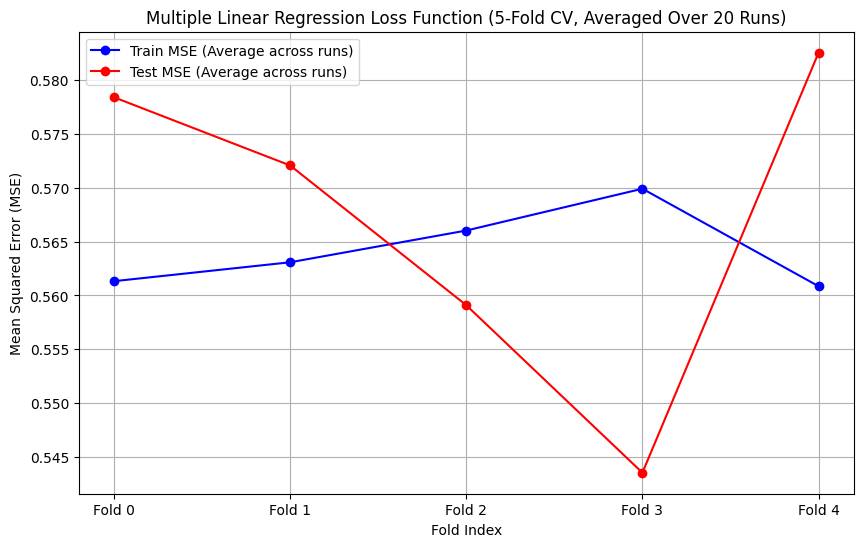

Accuracy with tolerance 0.5: 0.5173540220498163
Mean Absolute Deviation (MAD): 0.5855213287012354
MSE train set:	 0.5642410812580083
MSE test set:	 0.5671308981730099

Number of inputs = 7
Average R^2 (train): 0.2804844723733981
Average R^2 (test): 0.27680273813158146


In [15]:
# Deploying Multiple Linear Regression
# Create the model
model_MR = LinearRegression()

X = winedata.drop('quality', axis=1)
y = winedata['quality']

# Separating the data for testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=10)

# Backward Elimination with pmax -> Different to paper
cols = list(X_train.columns)
pmax = 1
while (len(cols) > 0):
    p = []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train, X_1).fit()
    p = pd.Series(model.pvalues.values[1:], index=cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if (pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_MR = cols

#print selected features
print(selected_features_MR)

# Creating new dataframe with only the selected features
selected_features_MR_winedata = winedata[selected_features_MR]

# Fitting the selected features to the pipeline that is already deployed
selected_features_MR_winedata_tr = transform_pipeline.fit_transform(selected_features_MR_winedata)

# Tolerance for accuracy
tolerance = 0.50

# Cross-validation preparation with stratification
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Number of runs for the cross-validation (same as paper)
n_runs = 20

# Variables to store results across all runs
all_MR_y_true = []
all_MR_y_pred = []
mse_MR_train_scores = []
mse_MR_test_scores = []
mad_MR_scores = []
r2_MR_train_scores = []
r2_MR_test_scores = []

# Outer loop to repeat the process for 20 runs
for run in range(n_runs):
    print(f"Run {run + 1}/{n_runs}...")

    # Cross-validation loop for the 5 folds
    for train_index, test_index in skf.split(selected_features_MR_winedata_tr, winedata["quality"]):
        X_MR_train, X_MR_test = selected_features_MR_winedata_tr[train_index], selected_features_MR_winedata_tr[test_index]
        y_MR_train, y_MR_test = winedata["quality"].iloc[train_index], winedata["quality"].iloc[test_index]

        model_MR.fit(X_MR_train, y_MR_train)

        # Prediction on the training set
        y_pred_MR_train = model_MR.predict(X_MR_train)

        # Calcutlation R^2 for the training set
        r2_MR_train = r2_score(y_MR_train, y_pred_MR_train)
        r2_MR_train_scores.append(r2_MR_train)

        # Predictions on the test set
        y_pred_MR_test = model_MR.predict(X_MR_test)

        # Calcutlation R^2 for the test set
        r2_MR_test = r2_score(y_MR_test, y_pred_MR_test)
        r2_MR_test_scores.append(r2_MR_test)

        # Calcutlation MSE for the training set
        mse_MR_train = mean_squared_error(y_MR_train, y_pred_MR_train)
        mse_MR_train_scores.append(mse_MR_train)

        # Calcutlation MSE for the test set
        mse_MR_test = mean_squared_error(y_MR_test, y_pred_MR_test)
        mse_MR_test_scores.append(mse_MR_test)

        # MAD across the folds for test set
        mad = mean_absolute_error(y_MR_test, y_pred_MR_test)
        mad_MR_scores.append(mad)

        # Storing the predicted and true values in the corresponding list for the test data
        all_MR_y_true.extend(y_MR_test)
        all_MR_y_pred.extend(y_pred_MR_test)

# Calculate average metrics after cross-validation (across all runs and folds)
avg_mse_train_MR = np.mean(mse_MR_train_scores)
avg_mse_test_MR = np.mean(mse_MR_test_scores)
avg_mad_MR = np.mean(mad_MR_scores)
avg_r2_train_MR = np.mean(r2_MR_train_scores)
avg_r2_test_MR = np.mean(r2_MR_test_scores)

# Aggregating and averaging MSE values for each fold across runs
avg_mse_train_per_fold = np.mean(np.array(mse_MR_train_scores).reshape(n_runs, n_splits), axis=0)
avg_mse_test_per_fold = np.mean(np.array(mse_MR_test_scores).reshape(n_runs, n_splits), axis=0)

# Plotting the average training and test MSE across folds (Loss-function)
plt.figure(figsize=(10, 6))
plt.plot(range(n_splits), avg_mse_train_per_fold, marker='o', label="Train MSE (Average across runs)", color="blue")
plt.plot(range(n_splits), avg_mse_test_per_fold, marker='o', label="Test MSE (Average across runs)", color="red")
plt.title("Multiple Linear Regression Loss Function (5-Fold CV, Averaged Over 20 Runs)")
plt.xlabel("Fold Index")
plt.ylabel("Mean Squared Error (MSE)")
plt.xticks(range(n_splits), [f"Fold {i}" for i in range(n_splits)])
plt.legend()
plt.grid(True)
plt.show()

# Calculate the accuracy with tolerance
correct_predictions_MR = np.abs(np.array(all_MR_y_true) - np.array(all_MR_y_pred)) <= tolerance
accuracy_with_tolerance_MR = np.mean(correct_predictions_MR)

# Printing the results
print(f"Accuracy with tolerance {tolerance}: {accuracy_with_tolerance_MR}")
print(f"Mean Absolute Deviation (MAD): {avg_mad_MR}")
print(f'MSE train set:\t {avg_mse_train_MR}')
print(f"MSE test set:\t {avg_mse_test_MR}\n")
print(f'Number of inputs = {selected_features_MR_winedata_tr.shape[1]}')
print(f"Average R^2 (train): {avg_r2_train_MR}")
print(f"Average R^2 (test): {avg_r2_test_MR}")


Heuristic values: C=3, epsilon=0.0066
Selected features: ['fixed acidity', 'volatile acidity', 'residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Best hyperparameter: gamma=2


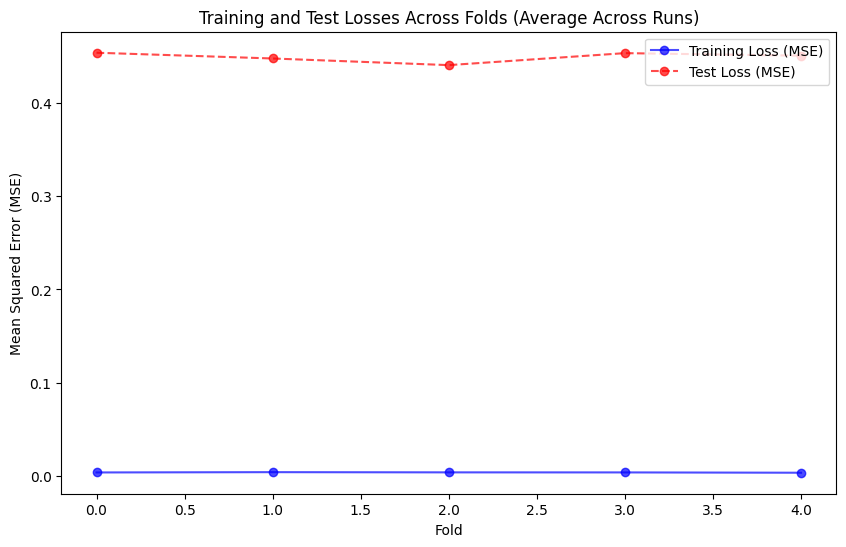

Accuracy with tolerance 0.5: 0.6607
Mean Absolute Deviation (MAD): 0.4252 ± 0.0147
Average R^2 (train): 0.9947
Average R^2 (test): 0.4275
Average MSE (train): 0.9947
Average MSE (test): 0.4275


In [16]:
#Support Vector Regression
# Define the MAD evaluation function
def mean_absolute_deviation(y_true_SVR, y_pred_SVR):
    return np.mean(np.abs(y_true_SVR - y_pred_SVR))

# Heuristic computation for epsilon
def compute_epsilon(X, y):
    N = len(y)

    # 3-Nearest Neighbor model
    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(X, y)
    y_pred_knn = knn.predict(X)

    # Compute b_epsilon
    b_epsilon = (1.5 / N) * np.sum((y - y_pred_knn) ** 2)

    # Compute epsilon
    epsilon = b_epsilon / np.sqrt(N)
    return epsilon

# Hyperparameter tuning function
def tune_hyperparameters(X, y, C, epsilon, gamma_range, metric=mean_absolute_deviation):
    best_score = float("inf")
    best_gamma = None

    for gamma in gamma_range:
        # Separating the data for testing and training
        X_train_scale, X_test_scale, y_train_scale, y_test_scale = train_test_split(X, y, test_size=1/3, random_state=42)

        # Standardizing the data
        scaler = StandardScaler()
        X_train_scale = scaler.fit_transform(X_train_scale)
        X_test_scale = scaler.transform(X_test_scale)

        # Train SVR with current hyperparameters
        model_SVR = SVR(C=C, epsilon=epsilon, gamma=gamma)
        model_SVR.fit(X_train_scale, y_train_scale)
        y_pred_scale = model_SVR.predict(X_test_scale)

        # MAD score
        score = metric(y_test_scale, y_pred_scale)

        if score < best_score:
            best_score = score
            best_gamma = gamma

    return best_gamma

# Creating the cross_validate function
def cross_validate(model, X, y, n_splits=5, n_runs=20, metric=mean_absolute_deviation):
    scores_MAD_SVR = []
    train_mse_SVR = []
    test_mse_SVR = []
    r2_SVR_train_scores = []
    r2_SVR_test_scores = []

    for run in range(n_runs):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=run)
        for train_idx, test_idx in kf.split(X):
            X_train_SVR, X_test_SVR = X[train_idx], X[test_idx]
            y_train_SVR, y_test_SVR = y[train_idx], y[test_idx]

            # Apply the transform pipeline (imputation and standardization)
            X_train_SVR_tr = transform_pipeline.fit_transform(X_train_SVR)
            X_test_SVR_tr = transform_pipeline.transform(X_test_SVR)

            # Clone the model for independent fitting -> Avoids data leackage
            cloned_model = clone(model)
            cloned_model.fit(X_train_SVR_tr, y_train_SVR)

            # Prediction for training set and test set
            y_train_pred_SVR = cloned_model.predict(X_train_SVR_tr)
            y_test_pred_SVR = cloned_model.predict(X_test_SVR_tr)

            # Evaluate using the specified metric (MAD)
            score_MAD_SVR = metric(y_test_SVR, y_test_pred_SVR)
            scores_MAD_SVR.append(score_MAD_SVR)

            # Predictions on the training set and R^2
            r2_train_SVR = r2_score(y_train_SVR, y_train_pred_SVR)
            r2_SVR_train_scores.append(r2_train_SVR)

            # Predictions on the test set and R^2
            r2_test_SVR = r2_score(y_test_SVR, y_test_pred_SVR)
            r2_SVR_test_scores.append(r2_test_SVR)

            # Calculate the MSE for both training and validation folds
            train_fold_mse_SVR = mean_squared_error(y_train_SVR, y_train_pred_SVR)
            test_fold_mse_SVR = mean_squared_error(y_test_SVR, y_test_pred_SVR)

            train_mse_SVR.append(train_fold_mse_SVR)
            test_mse_SVR.append(test_fold_mse_SVR)

    # Calculate mean and std for the MAD scores
    mean_metric_SVR = np.mean(scores_MAD_SVR)
    std_metric_SVR = np.std(scores_MAD_SVR)

    # Averaging the MSE values across all runs for each fold
    mean_train_mse_per_fold_SVR = np.mean(np.array(train_mse_SVR).reshape(n_runs, n_splits), axis=0)
    mean_test_mse_per_fold_SVR = np.mean(np.array(test_mse_SVR).reshape(n_runs, n_splits), axis=0)

    # Calculating overall average MSE by taking the mean of the average mean values of each fold => This was so confusing :D
    avg_mse_train_MR = np.mean(mean_train_mse_per_fold_SVR)
    avg_mse_test_MR = np.mean(mean_test_mse_per_fold_SVR)

    # Calculate average R^2 for the training and test sets
    avg_r2_train_SVR = np.mean(r2_SVR_train_scores)
    avg_r2_test_SVR = np.mean(r2_SVR_test_scores)

    # Plot the training and validation losses for each fold (Loss-function)
    plt.figure(figsize=(10, 6))
    plt.plot(mean_train_mse_per_fold_SVR, label='Training Loss (MSE)', color='blue', linestyle='-', marker='o', alpha=0.7)
    plt.plot(mean_test_mse_per_fold_SVR, label='Test Loss (MSE)', color='red', linestyle='--', marker='o', alpha=0.7)
    plt.xlabel('Fold')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Training and Test Losses Across Folds (Average Across Runs)')
    plt.legend(loc='upper right')
    plt.show()

    return mean_metric_SVR, std_metric_SVR, avg_r2_train_SVR, avg_r2_test_SVR, avg_r2_train_SVR, avg_r2_test_SVR

# Creating the variable_selection function
def variable_selection(X, y, C, epsilon, gamma_range, metric=mean_absolute_deviation, max_iter=2):
    selected_features_SVR = list(X.columns)
    best_gamma = None
    no_improvement_count = 0
    best_score = float("inf")

    while len(selected_features_SVR) > 1 and no_improvement_count < max_iter:
        current_score = float("inf")
        least_important_feature = None

        # Tuning gamma hyperparameter
        best_gamma = tune_hyperparameters(X[selected_features_SVR], y, C, epsilon, gamma_range, metric)

        # Separating the data for testing and training (holdout split)
        X_train_SVR, X_test_SVR, y_train_SVR, y_test_SVR = train_test_split(X[selected_features_SVR], y, test_size=1/3, random_state=42)

        # Apply the transform pipeline (imputation and standardization)
        X_train_SVR = transform_pipeline.fit_transform(X_train_SVR)
        X_test_SVR = transform_pipeline.transform(X_test_SVR)

        # Train model with best hyperparameters
        model_SVR = SVR(C=C, epsilon=epsilon, gamma=best_gamma)
        model_SVR.fit(X_train_SVR, y_train_SVR)

        # Calculate permutation importance
        importances_SVR = permutation_importance(model_SVR, X_test_SVR, y_test_SVR, scoring="neg_mean_absolute_error", random_state=42)
        importances_mean_SVR = importances_SVR.importances_mean

        # Identifying least important feature
        least_important_feature_SVR = selected_features_SVR[np.argmin(importances_mean_SVR)]

        # Removing least important feature
        temp_features_SVR = [f for f in selected_features_SVR if f != least_important_feature_SVR]
        X_temp_SVR = X[temp_features_SVR]

        # Validate the new model
        X_train_SVR, X_test_SVR, y_train_SVR, y_test_SVR = train_test_split(X_temp_SVR, y, test_size=1/3, random_state=42)
        X_train_SVR = transform_pipeline.fit_transform(X_train_SVR)
        X_test_SVR = transform_pipeline.transform(X_test_SVR)
        model_SVR.fit(X_train_SVR, y_train_SVR)
        y_pred_SVR = model_SVR.predict(X_test_SVR)

        # Calculate MAD
        score = metric(y_test_SVR, y_pred_SVR)

        if score < best_score:
            best_score = score
            selected_features_SVR.remove(least_important_feature_SVR)
            no_improvement_count = 0
        else:
            no_improvement_count += 1

    return selected_features_SVR, best_gamma


# Creating the main function
def main():
    # Defining X and y
    X = winedata.drop(columns=["quality"])
    y = winedata["quality"].values

    # Defining gamma ranges
    gamma_range = [2**i for i in range(3, -16, -2)]

    # Setting C and calculating epsilon using the already defined function
    C = 3
    epsilon = compute_epsilon(X.values, y)
    print(f"Heuristic values: C={C}, epsilon={epsilon:.4f}")

    # Calcualting gamma with the already defined hyperparameters C and epsilon
    selected_features_SVR, best_gamma_SVR = variable_selection(X, y, C, epsilon, gamma_range)

    # Printing the selected features and the best gamma
    print(f"Selected features: {selected_features_SVR}")
    print(f"Best hyperparameter: gamma={best_gamma_SVR}")

    # Creating a new column with the the selected features
    X_selected_SVR = X[selected_features_SVR]

    # Training final SVR model
    final_model_SVR = SVR(C=C, epsilon=epsilon, gamma=best_gamma_SVR)

    # Performing cross-validation
    mean_mad_SVR, std_mad_SVR, avg_r2_train_SVR, avg_r2_test_SVR, avg_mse_train_SVR, avg_mse_test_SVR = cross_validate(
        final_model_SVR, X_selected_SVR.values, y, n_splits=5, n_runs=20
    )


    #Tolerance
    tolerance = 0.50

    # Store all predictions and true values from CV
    all_y_true_SVR, all_y_pred_SVR = [], []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, test_idx in kf.split(X_selected_SVR):
        X_train_SVR, X_test_SVR = X_selected_SVR.values[train_idx], X_selected_SVR.values[test_idx]
        y_train_SVR, y_test_SVR = y[train_idx], y[test_idx]

        # Standardizing the data
        scaler_SVR = StandardScaler()
        X_train_SVR = scaler_SVR.fit_transform(X_train_SVR)
        X_test_SVR = scaler_SVR.transform(X_test_SVR)

        # Predicting y with the test data
        final_model_SVR.fit(X_train_SVR, y_train_SVR)
        y_pred_SVR = final_model_SVR.predict(X_test_SVR)

        # Appending results for evaluation to the defined lists
        all_y_true_SVR.extend(y_test_SVR)
        all_y_pred_SVR.extend(y_pred_SVR)

    # Calculate accuracy with tolerance
    correct_predictions_SVR = np.abs(np.array(all_y_true_SVR) - np.array(all_y_pred_SVR)) <= tolerance
    accuracy_with_tolerance_SVR = np.mean(correct_predictions_SVR)

    # Print final evaluation results
    print(f"Accuracy with tolerance {tolerance}: {accuracy_with_tolerance_SVR:.4f}")
    print(f"Mean Absolute Deviation (MAD): {mean_mad_SVR:.4f} ± {std_mad_SVR:.4f}")
    print(f"Average R^2 (train): {avg_r2_train_SVR:.4f}")
    print(f"Average R^2 (test): {avg_r2_test_SVR:.4f}")
    print(f"Average MSE (train): {avg_mse_train_SVR:.4f}")
    print(f"Average MSE (test): {avg_mse_test_SVR:.4f}")

if __name__ == "__main__":
    main()



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Selected features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates']
Best H: 1
Best score (MAD): 2.1875


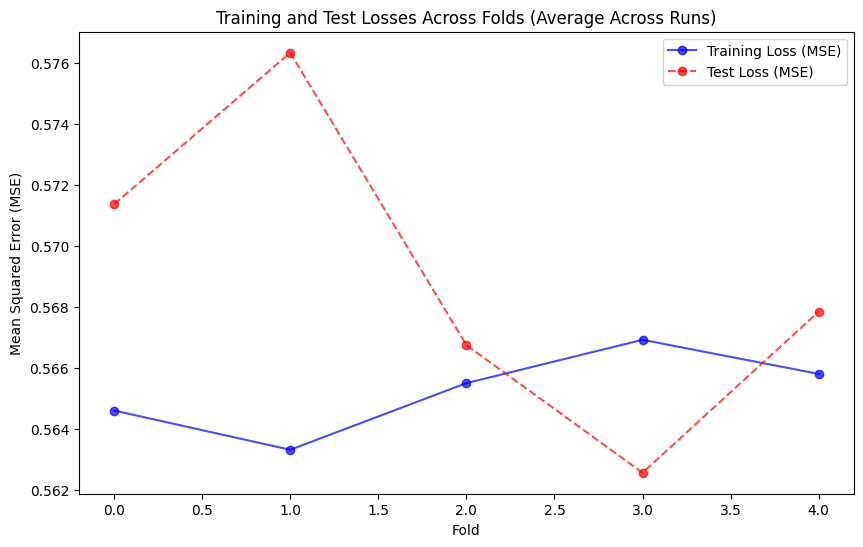

Accuracy with tolerance 0.5: 0.5147
Mean Absolute Deviation (MAD): 0.5868 ± 0.0149
Average R^2 (train): 0.2792
Average R^2 (test): 0.2740
Average MSE (train)): 0.5652
Average MSE (test): 0.5690


In [17]:
#Neural Network

# Define the MAD evaluation function
def mean_absolute_deviation(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Function to find  H
def search_optimal_H(X, y, Hmax, metric=mean_absolute_deviation):
    best_score_NN = float("inf")
    best_H = 0
    previous_score = float("inf")

    for H in range(1, Hmax + 1):
        # Separating the data for testing and training (holdout split)
        X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X, y, test_size=1/3, random_state=42)

        # Standardizing the data
        scaler_NN = StandardScaler()
        X_train_NN = scaler_NN.fit_transform(X_train_NN)
        X_test_NN = scaler_NN.transform(X_test_NN)

        # Train NN with current H
        model_NN = MLPRegressor(hidden_layer_sizes=(H,), random_state=42, max_iter=100, early_stopping=True, validation_fraction=0.1)
        model_NN.fit(X_train_NN, y_train_NN)
        y_pred_NN = model_NN.predict(X_test_NN)

        # Compute MAD with defined function
        score_NN = metric(y_test_NN, y_pred_NN)

        # Checking if generalization improves
        if score_NN < best_score_NN:
            best_score_NN = score_NN
            best_H = H
            previous_score_NN = score_NN
        else:
            # Stop search if generalization decreases
            if score_NN > previous_score_NN:
                break
            previous_score = score_NN

    return best_H, best_score_NN

# Deploying a function for cross-validation
def cross_validate(model, X, y, n_splits=5, n_runs=20, metric=mean_absolute_deviation):
    scores_NN = []
    train_mse_NN = []
    test_mse_NN = []
    r2_NN_train_scores = []
    r2_NN_test_scores = []
    all_y_true_NN = []
    all_y_pred_NN = []

    for run in range(n_runs):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=run)
        for train_idx, test_idx in kf.split(X):
            X_train_NN, X_test_NN = X[train_idx], X[test_idx]
            y_train_NN, y_test_NN = y[train_idx], y[test_idx]

            # Apply the transform pipeline (imputation and standardization)
            X_train_NN_tr = transform_pipeline.fit_transform(X_train_NN)
            X_test_NN_tr = transform_pipeline.transform(X_test_NN)

            # Clone the model for independent fitting -> Avoids data leakage
            cloned_model = clone(model)
            cloned_model.fit(X_train_NN_tr, y_train_NN)

            # Predicting for training set and test set
            y_train_pred_NN = cloned_model.predict(X_train_NN_tr)
            y_test_pred_NN = cloned_model.predict(X_test_NN_tr)

            # Storing the true and predicted values for the test set
            all_y_true_NN.extend(y_test_NN)
            all_y_pred_NN.extend(y_test_pred_NN)

            # Calculating MAD score
            score_NN = metric(y_test_NN, y_test_pred_NN)
            scores_NN.append(score_NN)

            # Calculating the R^2 value for the training data
            r2_train_NN = r2_score(y_train_NN, y_train_pred_NN)
            r2_NN_train_scores.append(r2_train_NN)

            # Calculating the R^2 value for the test data
            r2_test_NN = r2_score(y_test_NN, y_test_pred_NN)
            r2_NN_test_scores.append(r2_test_NN)

            # Calculating the MSE for both training and test folds
            train_fold_mse_NN = mean_squared_error(y_train_NN, y_train_pred_NN)
            test_fold_mse_NN = mean_squared_error(y_test_NN, y_test_pred_NN)
            train_mse_NN.append(train_fold_mse_NN)
            test_mse_NN.append(test_fold_mse_NN)

    # Calculate mean and std for the MAD scores
    mean_metric_NN = np.mean(scores_NN)
    std_metric_NN = np.std(scores_NN)

    # Averaging the MSE values across all runs for each fold
    mean_train_mse_per_fold_NN = np.mean(np.array(train_mse_NN).reshape(n_runs, n_splits), axis=0)
    mean_test_mse_per_fold_NN = np.mean(np.array(test_mse_NN).reshape(n_runs, n_splits), axis=0)

    # Calculating overall average MSE by taking the mean of the average mean values of each fold
    avg_mse_train_NN = np.mean(mean_train_mse_per_fold_NN)
    avg_mse_test_NN = np.mean(mean_test_mse_per_fold_NN)

    # Calculate average R^2 for the training and test sets
    avg_r2_train_NN = np.mean(r2_NN_train_scores)
    avg_r2_test_NN = np.mean(r2_NN_test_scores)

    # Plotting the loss function
    plt.figure(figsize=(10, 6))
    plt.plot(mean_train_mse_per_fold_NN, label='Training Loss (MSE)', color='blue', linestyle='-', marker='o', alpha=0.7)
    plt.plot(mean_test_mse_per_fold_NN, label='Test Loss (MSE)', color='red', linestyle='--', marker='o', alpha=0.7)
    plt.xlabel('Fold')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Training and Test Losses Across Folds (Average Across Runs)')
    plt.legend(loc='upper right')
    plt.show()

    return mean_metric_NN, std_metric_NN, avg_r2_train_NN, avg_r2_test_NN, avg_mse_train_NN, avg_mse_test_NN, all_y_true_NN, all_y_pred_NN

# Feature selection function
def variable_selection(X, y, Hmax, metric=mean_absolute_deviation, max_iter=5):
    selected_features_NN = list(X.columns)
    best_score_NN = float("inf")
    no_improvement_count_NN = 0
    best_H = 0

    while len(selected_features_NN) > 1 and no_improvement_count_NN < max_iter:
        current_score_NN = float("inf")
        least_important_feature_NN = None

        # Train model with the selected features
        best_H, _ = search_optimal_H(X[selected_features_NN], y, Hmax, metric)
        model_NN = MLPRegressor(hidden_layer_sizes=(best_H,), random_state=42, max_iter=100, early_stopping=True, validation_fraction=0.1)

        # Split the data and standardizing
        X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X[selected_features_NN], y, test_size=1/3, random_state=42)
        scaler_NN = StandardScaler()
        X_train_NN = scaler_NN.fit_transform(X_train_NN)
        X_test_NN = scaler_NN.transform(X_test_NN)

        # Train the model
        model_NN.fit(X_train_NN, y_train_NN)
        y_pred_NN = model_NN.predict(X_test_NN)

        # Calculate permutation importance
        importances_NN = permutation_importance(model_NN, X_test_NN, y_test_NN, scoring="neg_mean_absolute_error", random_state=42)
        importances_mean_NN = importances_NN.importances_mean

        # Identifying least important feature
        least_important_feature_NN = selected_features_NN[np.argmin(importances_mean_NN)]

        # Removing least important feature
        temp_features_NN = [f for f in selected_features_NN if f != least_important_feature_NN]
        X_temp_NN = X[temp_features_NN]

        # Validating the new model
        X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X_temp_NN, y, test_size=1/3, random_state=42)
        X_train_NN = scaler_NN.fit_transform(X_train_NN)
        X_test_NN = scaler_NN.transform(X_test_NN)
        model_NN.fit(X_train_NN, y_train_NN)
        y_pred_NN = model_NN.predict(X_test_NN)

        # Calculating MAD
        score_NN = metric(y_test_NN, y_pred_NN)

        if score_NN < best_score_NN:
            best_score_NN = score_NN
            selected_features_NN.remove(least_important_feature_NN)
            no_improvement_count_NN = 0
        else:
            no_improvement_count_NN += 1

    return selected_features_NN, best_H, best_score_NN

# Defining the main function
def main():

    X = winedata.drop(columns=["quality"])
    y = winedata["quality"].values

    # Defining the maximum number of neurons
    Hmax = 64

    # Tolerance
    tolerance = 0.5

    # Feature selection
    selected_features_NN, best_H, best_score_NN = variable_selection(X, y, Hmax)
    print(f"Selected features: {selected_features_NN}")
    print(f"Best H: {best_H}")
    print(f"Best score (MAD): {best_score_NN:.4f}")

    # Training final model using the selected features
    final_model_NN = MLPRegressor(
        hidden_layer_sizes=(best_H,),
        random_state=42,
        max_iter=1000,
        early_stopping=True,
        validation_fraction=0.1)

    # Perform 20 runs of 5-fold cross-validation
    mean_mad_NN, std_mad_NN, avg_r2_train_NN, avg_r2_test_NN, avg_mse_train_NN, avg_mse_test_NN, all_y_true_NN, all_y_pred_NN = cross_validate(
        final_model_NN, X[selected_features_NN].values, y, n_splits=5, n_runs=20)

    # Creating a dictionary to store the results
    results_NN = {
        "accuracy_with_tolerance_NN": 0,
        "mean_mad_NN": mean_mad_NN,
        "std_mad_NN": std_mad_NN,
        "avg_r2_train_NN": avg_r2_train_NN,
        "avg_r2_test_NN": avg_r2_test_NN,
        "all_mse_train_scores_NN": [],
        "all_mse_test_scores_NN": [],
        "all_y_true_NN": all_y_true_NN,
        "all_y_pred_NN": all_y_pred_NN,
    }

    # Calculate accuracy with tolerance
    correct_predictions_NN = np.abs(np.array(all_y_true_NN) - np.array(all_y_pred_NN)) <= tolerance
    accuracy_with_tolerance_NN = np.mean(correct_predictions_NN)

    # Print the results
    print(f"Accuracy with tolerance {tolerance}: {accuracy_with_tolerance_NN:.4f}")
    print(f"Mean Absolute Deviation (MAD): {mean_mad_NN:.4f} ± {std_mad_NN:.4f}")
    print(f"Average R^2 (train): {avg_r2_train_NN:.4f}")
    print(f"Average R^2 (test): {avg_r2_test_NN:.4f}")
    print(f"Average MSE (train)): {avg_mse_train_NN:.4f}")
    print(f"Average MSE (test): {avg_mse_test_NN:.4f}")

if __name__ == "__main__":
    main()

Best depth found: 5
Accuracy with tolerance 0.5: 0.5492
Mean Absolute Deviation (MAD): 0.5481
Mean Squared Error (MSE): 0.4966
R-squared: 0.3667


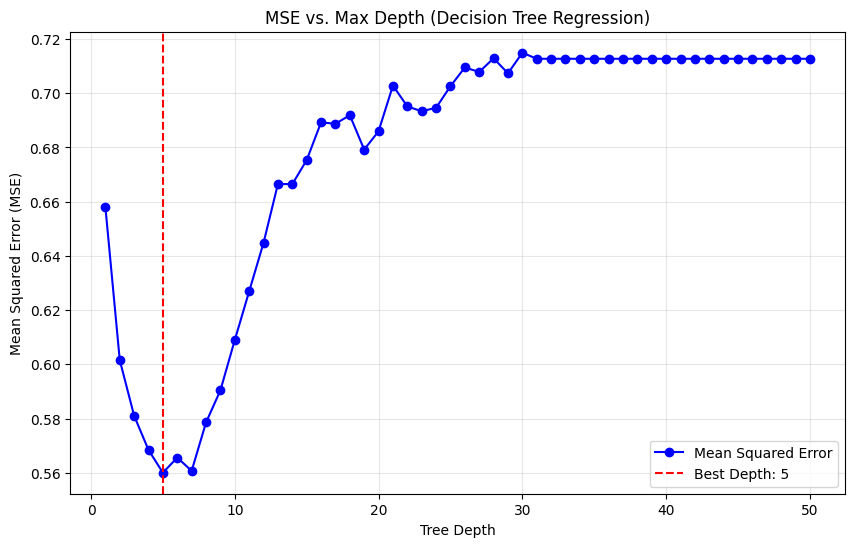

In [18]:
# Decision Tree

# Defining Features (X) and target variable (y)
X = winedata.drop('quality', axis=1)
y = winedata['quality']

# Apply the pipeline to preprocess X
X_transformed = transform_pipeline.fit_transform(X)
X_transformed = pd.DataFrame(X_transformed, columns=X.columns)

# Decision Tree model with explicit random_state
regr = DecisionTreeRegressor(random_state=42)

# Combining the transform_pipeline and regr in a pipeline
pipeline = Pipeline([
    ('transform', transform_pipeline),
    ('regressor', regr)
])

# Defining the parameter grid for the depth search
param_grid = {'regressor__max_depth': range(1, 51)}


# Binning for stratification
num_bins = 3
binner = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='quantile')
y_binned = binner.fit_transform(y.values.reshape(-1, 1)).flatten()

# Defining the cross-validation with stratification
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search with StratifiedKFold
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=skf.split(X_transformed, y_binned),  # Pass binned target for stratification
                           refit=True)

# Fitting the grid_search to the data
grid_search.fit(X_transformed, y)

# Searching for the best depth and pipeline
best_depth = grid_search.best_params_['regressor__max_depth']
best_pipeline = grid_search.best_estimator_

print(f"Best depth found: {best_depth}")

# Tolerance for accuracy
tolerance = 0.5

# Predicting on the entire dataset with the best pipeline
y_pred_all = best_pipeline.predict(X_transformed)

# Calculate accuracy with tolerance
correct_predictions = np.abs(y - y_pred_all) <= tolerance
accuracy_with_tolerance = np.mean(correct_predictions)

# Mean Absolute Deviation (MAD)
mad = np.mean(np.abs(y - y_pred_all))

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y, y_pred_all)

# Calculate R^2
r2 = r2_score(y, y_pred_all)

# Extracting results from grid_search
results = grid_search.cv_results_

# Converting neg_mean_squared_error to mean_squared_error
mean_test_scores = -results['mean_test_score']

# Extracting the the depth from param_grid
depths = param_grid['regressor__max_depth']

# Print results
print(f"Accuracy with tolerance {tolerance}: {accuracy_with_tolerance:.4f}")
print(f"Mean Absolute Deviation (MAD): {mad:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared: {r2:.4f}")

# Plotting MSE vs. max_depth
plt.figure(figsize=(10, 6))
plt.plot(depths, mean_test_scores, marker='o', linestyle='-', color='blue', label="Mean Squared Error")
plt.axvline(x=best_depth, color='red', linestyle='--', label=f"Best Depth: {best_depth}")
plt.xlabel("Tree Depth")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs. Max Depth (Decision Tree Regression)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 380}


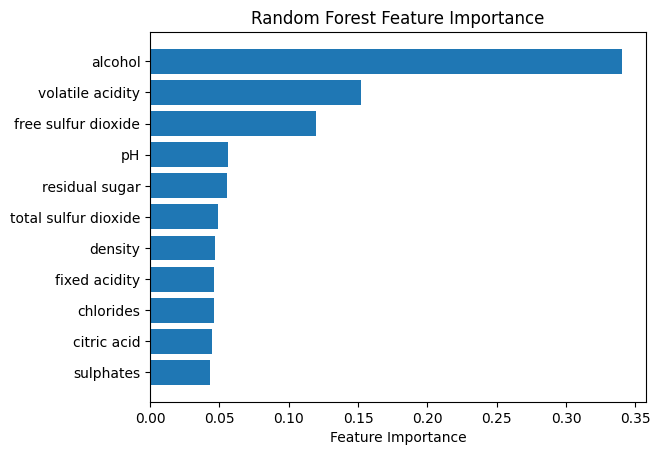

Mean MSE: 0.2616 ± 0.0151
Mean MAE: 0.3949 ± 0.0098
Mean R^2: 0.6660 ± 0.0158
Accuracy with tolerance 0.5: 0.7056


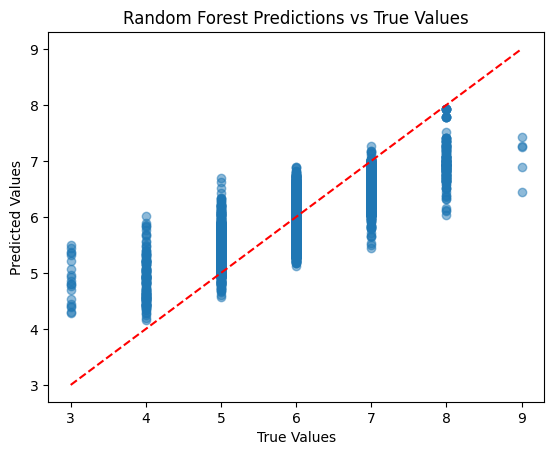

In [19]:
# Random Forest
# Features (X) and target variable (y)
X = winedata.drop('quality', axis=1)
y = winedata['quality']

# Apply the pipeline to preprocess X
X_transformed = transform_pipeline.fit_transform(X)

# Hyperparameter search
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=2,
    random_state=42
)

# Deploying the hyperparameter search
random_search.fit(X_transformed, y)
best_rf_model = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")

# Plotting feature importance
feature_importances = best_rf_model.feature_importances_
sorted_idx = np.argsort(feature_importances)
plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

# Defining a function for the random forest with cv and metrics
def random_forest(model, X, y, n_splits=5, tolerance=0.5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Creating
    mse_scores, mae_scores, r2_scores, accuracy_scores = [], [], [], []

    for train_RF, test_RF in kf.split(X):
        X_train, X_test = X[train_RF], X[test_RF]
        y_train, y_test = y[train_RF], y[test_RF]

        # Predictions on the test set
        y_pred = model.predict(X_test)

        # Metrics
        mse_scores.append(mean_squared_error(y_test, y_pred))
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))

        # Accuracy with tolerance
        correct_predictions = np.abs(y_test - y_pred) <= tolerance
        accuracy_scores.append(np.mean(correct_predictions))

    # Printing the metric values
    print(f"Mean MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
    print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"Mean R^2: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"Accuracy with tolerance {tolerance}: {np.mean(accuracy_scores):.4f}")

    return np.mean(mse_scores), np.mean(mae_scores), np.mean(r2_scores)

# Evaluate the tuned model
random_forest(best_rf_model, X_transformed, y, tolerance=0.5)

# Plotting the predichtions
y_pred = best_rf_model.predict(X_transformed)
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest Predictions vs True Values")
plt.show()
